# APS - new snow

## Imports

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
from __future__ import print_function
import pylab as plt
import datetime
import numpy as np
plt.rcParams['figure.figsize'] = (14, 6)

## Parameters, categories and scores

### Main control factors

In [2]:
# New snow amount last 24 h 0-60 cm [10 cm intervals]
new_snow_24h_cat = np.array([0, 10, 20, 30, 40, 50, 60])
new_snow_24h_score = np.array([0.1, 0.5, 1.1, 1.3, 1.4, 1.8, 2.0])

# Wind speed 0-100 km/h [0,10,20,30,40,50,60,80,100]
wind_speed_km_cat = np.array([-5, 0, 10, 20, 30, 40, 50, 60, 80, 100, 150])
wind_speed_cat = wind_speed_km_cat / 3.6 # m/s
wind_speed_score = np.array([0.0, 1.8, 2.8, 3.3, 2.6, 1.2, 0.6, 0.3, 0.15, 0.07, 0.0])

### Weighting
Weights are added if they are independent of the value of the core factor or multiplied if they are related to the core factor.

In [3]:
# New snow amount last 24-72h 0-100 cm [0,10,20,30,40,50,60,80,100]
new_snow_24_72h_cat = np.array([0, 10, 20, 30, 40, 50, 60, 80, 100])
new_snow_24_72h_score = np.array([0.8, 1.0, 1.1, 1.2, 1.4, 1.6, 1.8, 2.1, 2.5]) # a weight for new_snow_24h

# Evolution of temperature
evolution_temperature_cat = ["constant very cold",
                             "constant cold",
                             "constant warm",
                             "rise towards 0 deg after snowfall",
                             "substantial cooling after snowfall"]

# Bonding to existing snowpack 
bonding_existing_snowpack_cat = ["favorable", "moderate", "poor"]

# Type of new snow 
type_new_snow_cat = ["loose-powder", "soft", "packed", "packed and moist"]

The *new_snow_24_72h_scores* are used to weight the *new_snow_24h_scores* prior to multiplying it with *wind_speed_score*.

In order to achive a smooth fit within the range of interest I added some control points just right outside the normal range for the higher order polynomials.

The temperature evolution during a snowfall can be fitted to a curve which can then be compared to predefined curves/scenarios. The scenario with the best correlation is chosen to define the category.

The *type_new_snow_cat* can be infered from *evolution_temperature* and *wind_speed*.

In the first place the categories can be set manually.

## Score functions

### New snow 24 h

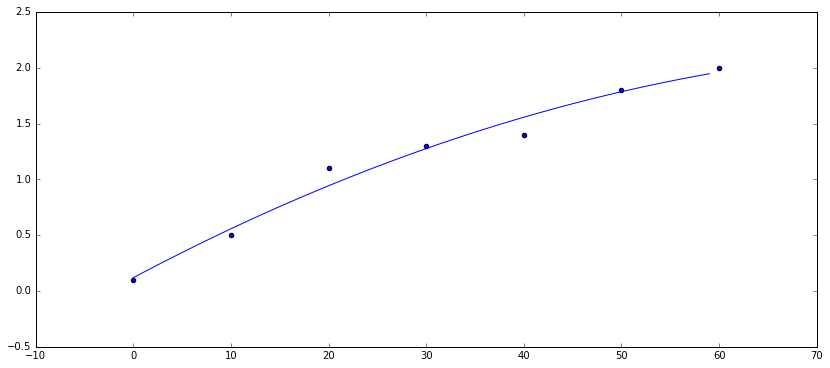

In [4]:
new_snow_24h_fit = np.polyfit(new_snow_24h_cat, new_snow_24h_score, 2)
score_new_snow_24h = np.poly1d(new_snow_24h_fit)

x = np.arange(0, 60.0)
res = score_new_snow_24h(x)

plt.scatter(new_snow_24h_cat, new_snow_24h_score)
plt.plot(x, res)

###New snow 24-72 h

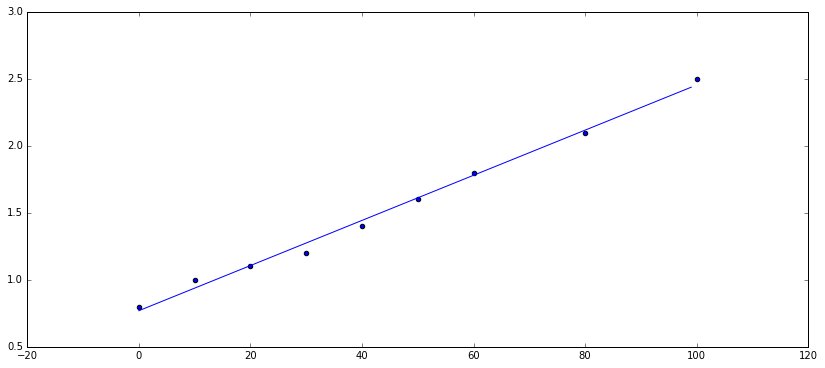

In [5]:
new_snow_24_72h_fit = np.polyfit(new_snow_24_72h_cat, new_snow_24_72h_score, 1)
score_new_snow_24_72h = np.poly1d(new_snow_24_72h_fit)

x = np.arange(0, 100.0)
res = score_new_snow_24_72h(x)

plt.scatter(new_snow_24_72h_cat, new_snow_24_72h_score)
plt.plot(x, res)

### Wind speed

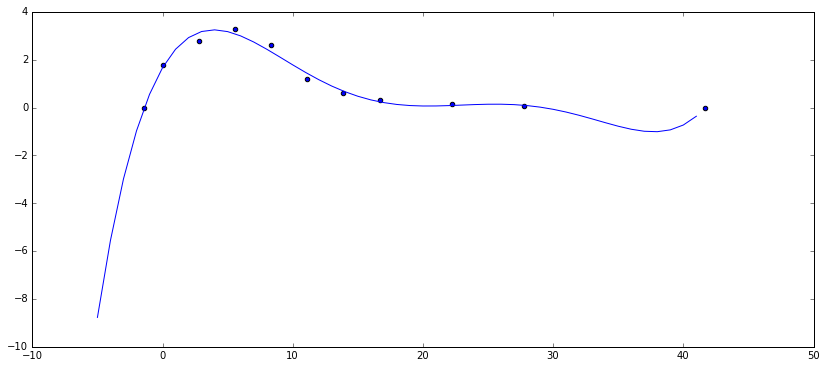

In [6]:
wind_speed_fit = np.polyfit(wind_speed_cat, wind_speed_score, 5)
score_wind_speed = np.poly1d(wind_speed_fit)

x = np.arange(-5, 150.0 / 3.6)
res = score_wind_speed(x)

plt.scatter(wind_speed_cat, wind_speed_score)
plt.plot(x, res)

## New snow vs. wind speed

Min 0.011936375845611873; Max 9.144800682316642


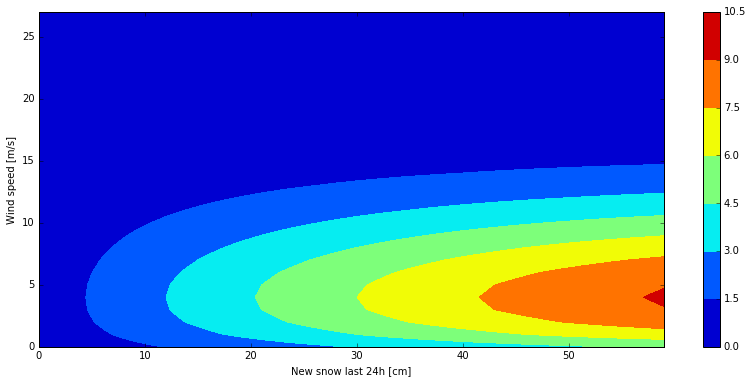

In [7]:
new_snow = np.matrix(np.arange(0, 60.0))
sns = score_new_snow_24h(new_snow)

# weighted by new snow amount of the previous two days
new_snow_72 = 40
ns_weight = score_new_snow_24_72h(new_snow_72)

sns *= ns_weight

wind_speed = np.matrix(np.arange(0, 100.0 / 3.6))
swp = score_wind_speed(wind_speed)

M = np.multiply(sns, swp.T)
#print(M)
plt.contourf(M)#np.flipud(M.T))
print("Min {0}; Max {1}".format(np.amin(M), np.amax(M)))
plt.colorbar()
plt.xlabel("New snow last 24h [cm]")
plt.ylabel("Wind speed [m/s]")

# ToDo

- calculate new_snow_score for some weeks
- compare to chosen AP in regional forecast
- maybe extent to a larger grid


...continue with hemsedal_jan2016.py in Test

## Working with real data
Load data from filefjell.db containing two weeks of met-data from the station.
The database was generated by the notebook "xgeo_chartserver".

In [21]:
import sqlite3
import pandas as pd

In [22]:
db_name = 'filefjell.db'
conn = sqlite3.connect(db_name)
cur = conn.cursor()

In [26]:
sql = "SELECT * from FILEFJELL"
df = pd.read_sql(sql, conn, index_col='index', parse_dates=['index'])
conn.close()
df.head()

,"FILEFJELL - KYRKJESTØLANE (54710), Nedbør (mm)","FILEFJELL - KYRKJESTØLANE (54710), Lufttemperatur (°C)","FILEFJELL - KYRKJESTØLANE (54710), Vindhastighet 10m (m/s)","FILEFJELL - KYRKJESTØLANE (54710), Snødybde (cm)"
index,,,,
2016-01-27 00:00:00,1.1,-2.1,4.7,48.0
2016-01-27 01:00:00,0.1,-1.9,3.9,49.0
2016-01-27 02:00:00,0.0,3.3,5.2,49.0
2016-01-27 03:00:00,0.0,4.1,7.3,49.0
2016-01-27 04:00:00,0.0,3.5,8.8,48.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000ADD9080>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000AEA9518>], dtype=object)

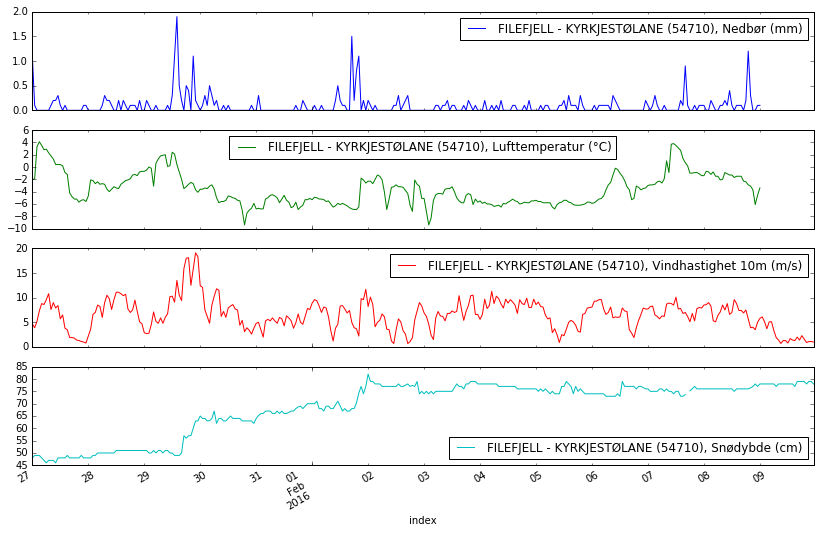

In [27]:
df.plot(subplots='True', figsize=(14, 9))

# Random scripting testing

In [7]:
new_snow_cat = ["0-5", "5-10", "10-15", "15-20"]
new_snow_thres = {(0, 5): 0.2, (5, 10): 0.5, (10, 15): 1, (15, 20): 3}

wind_cat = ["0-3", "4-7", "8-10", "10-15", "16-30"]
wind_thres = {(0, 3): 0.2, (3, 7): 1, (7, 10): 2, (10, 15): 0.2, (15, 30): 0.01}


new_snow_region = np.array([[0, 4, 6, 18],
                             [0, 4, 6, 18],
                             [0, 4, 6, 18]])

wind_region = np.array([[0, 4, 12, 18],
                         [4, 0, 18, 6],
                         [18, 12, 6, 0]])

In [74]:
def get_score(a, score_dict):
    for key, value in score_dict.items():
        if key[0] <= a < key[1]:
    #    if a < key:
            return value
            break
    return None

the dict is not sorted and the comparison *less than* is random...

In [75]:
new_snow_region_score = [get_score(a, new_snow_thres) for a in new_snow_region.flatten()]
new_snow_region_score = np.array(new_snow_region_score).reshape(new_snow_region.shape)
print(new_snow_region_score)

[[ 0.2  0.2  0.5  3. ]
 [ 0.2  0.2  0.5  3. ]
 [ 0.2  0.2  0.5  3. ]]


In [76]:
wind_region_score = [get_score(a, wind_thres) for a in wind_region.flatten()]
wind_region_score = np.array(wind_region_score).reshape(wind_region.shape)
print(wind_region_score)

[[ 0.2   1.    0.2   0.01]
 [ 1.    0.2   0.01  1.  ]
 [ 0.01  0.2   1.    0.2 ]]


In [77]:
print(wind_region_score * new_snow_region_score)

[[  4.00000000e-02   2.00000000e-01   1.00000000e-01   3.00000000e-02]
 [  2.00000000e-01   4.00000000e-02   5.00000000e-03   3.00000000e+00]
 [  2.00000000e-03   4.00000000e-02   5.00000000e-01   6.00000000e-01]]


[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]]
[[ 10.]
 [ 11.]
 [ 12.]
 [ 13.]
 [ 14.]
 [ 15.]
 [ 16.]
 [ 17.]
 [ 18.]
 [ 19.]
 [ 20.]]
[[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]
 [   0.   11.   22.   33.   44.   55.   66.   77.   88.   99.  110.]
 [   0.   12.   24.   36.   48.   60.   72.   84.   96.  108.  120.]
 [   0.   13.   26.   39.   52.   65.   78.   91.  104.  117.  130.]
 [   0.   14.   28.   42.   56.   70.   84.   98.  112.  126.  140.]
 [   0.   15.   30.   45.   60.   75.   90.  105.  120.  135.  150.]
 [   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.]
 [   0.   17.   34.   51.   68.   85.  102.  119.  136.  153.  170.]
 [   0.   18.   36.   54.   72.   90.  108.  126.  144.  162.  180.]
 [   0.   19.   38.   57.   76.   95.  114.  133.  152.  171.  190.]
 [   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.]]
Min 0.0; Max 200.0


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


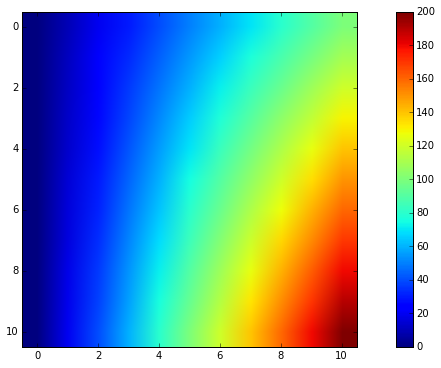

In [86]:
X = np.matrix(np.arange(0, 11.0))
Y = np.matrix(np.arange(10.0, 21.0))

Z = np.multiply(X, Y.T)
print(X)
print(Y.T)
print(Z)
plt.imshow(Z)
print("Min {0}; Max {1}".format(np.amin(Z), np.amax(Z)))
plt.colorbar()